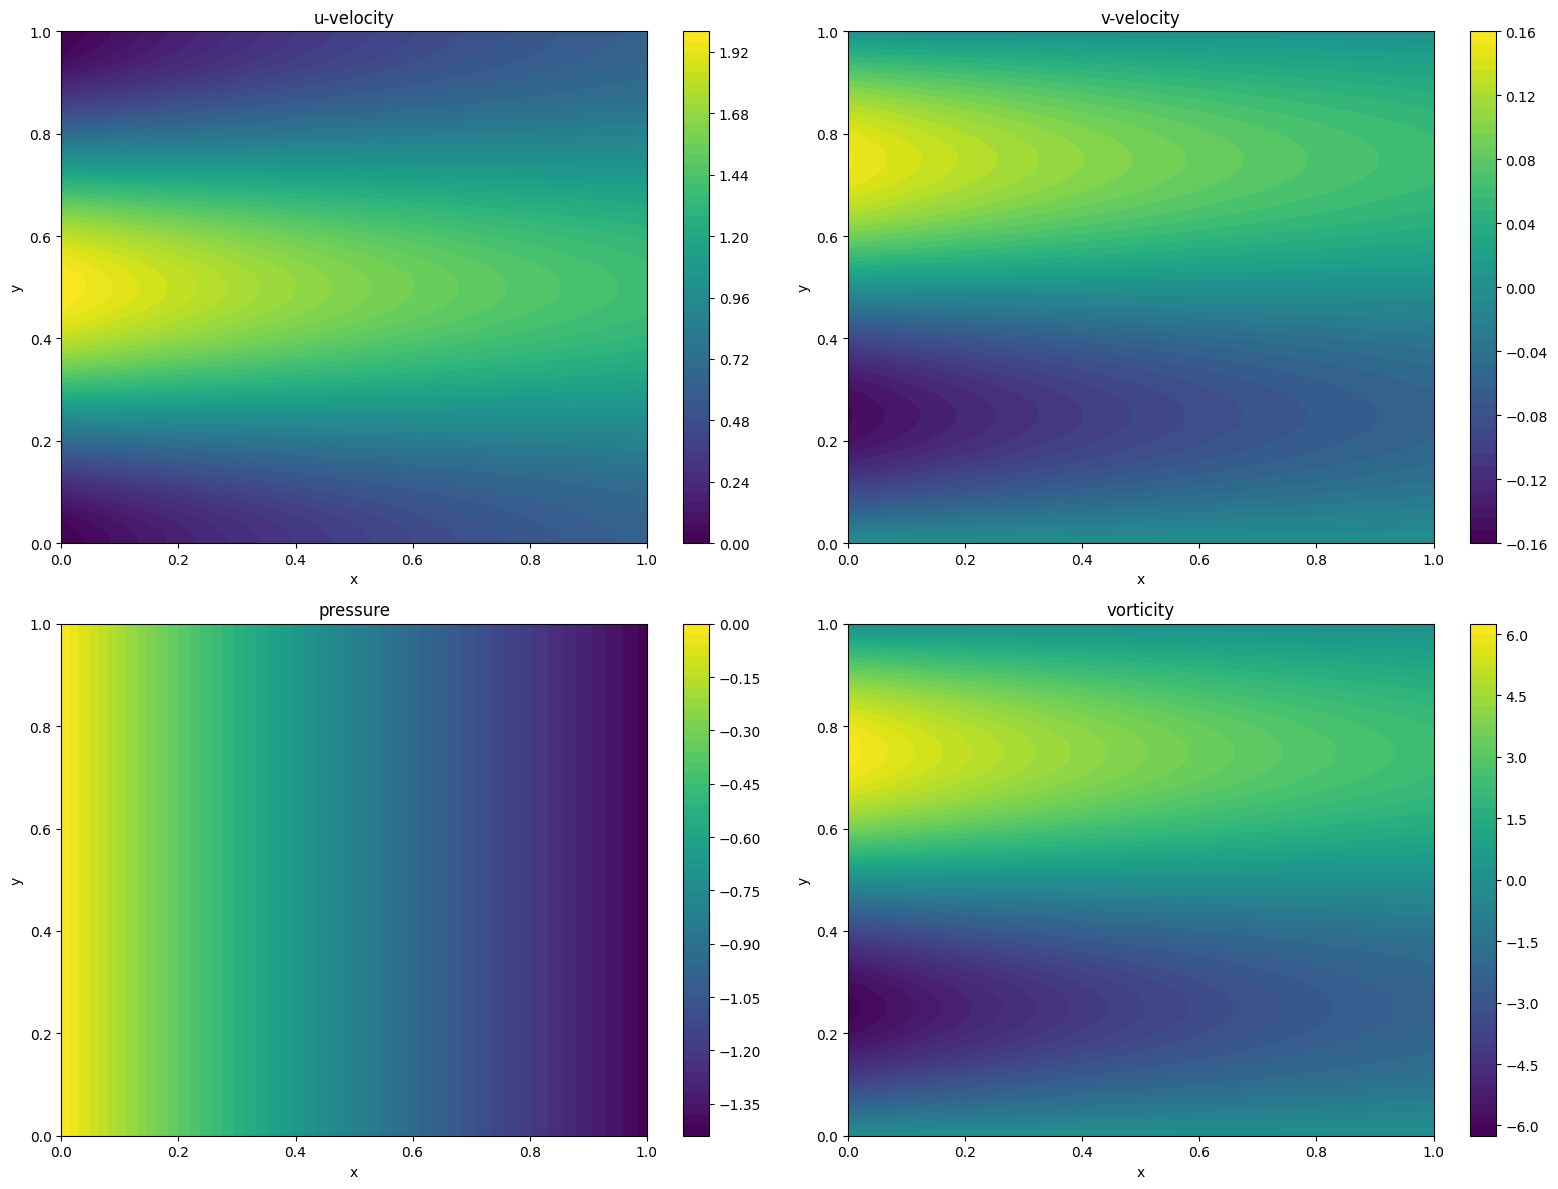

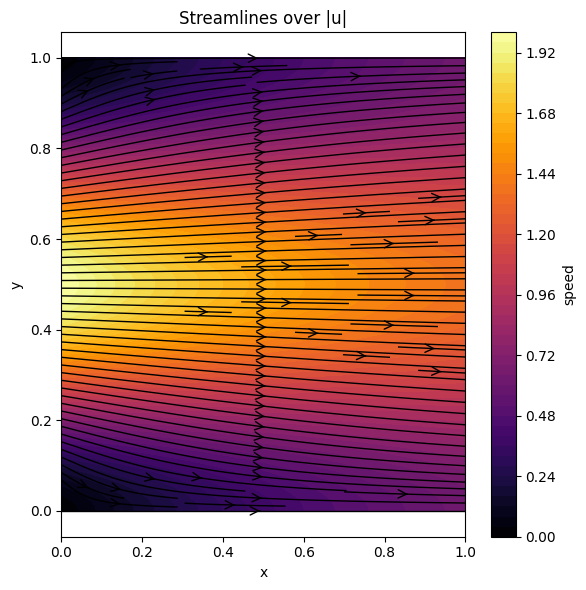

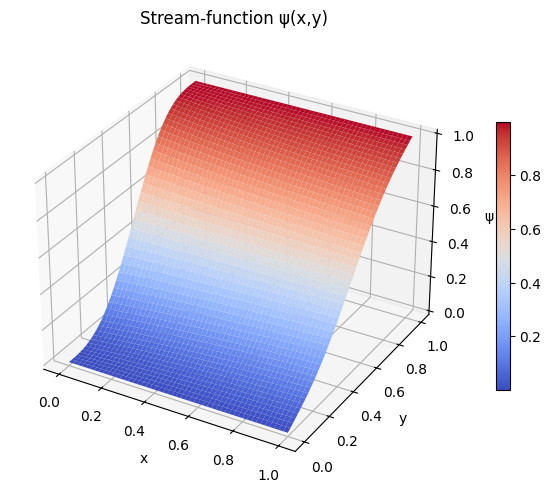

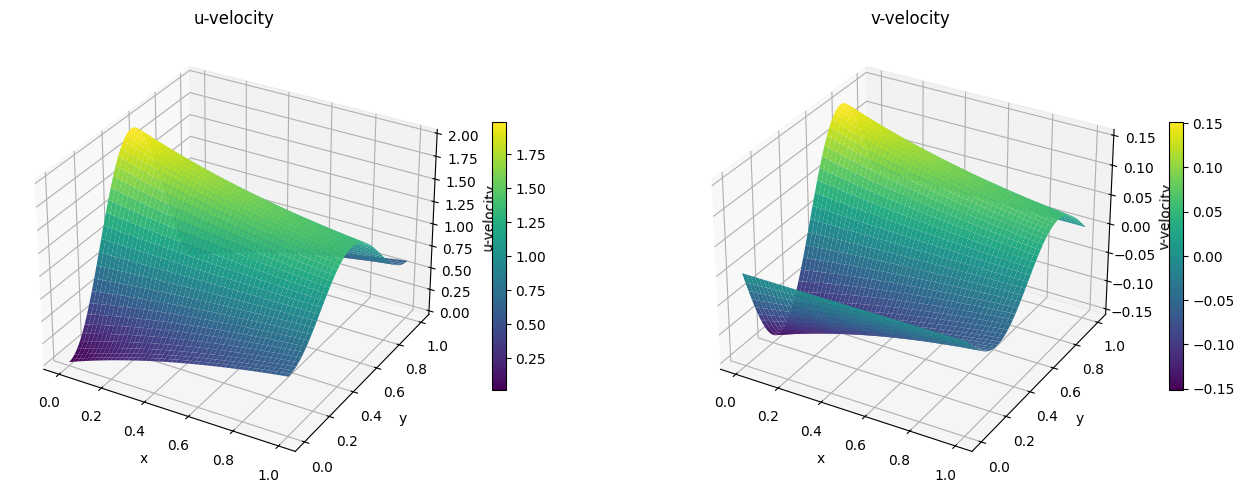

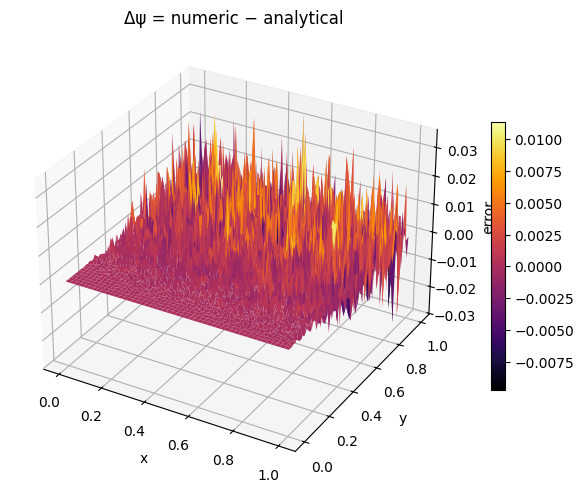

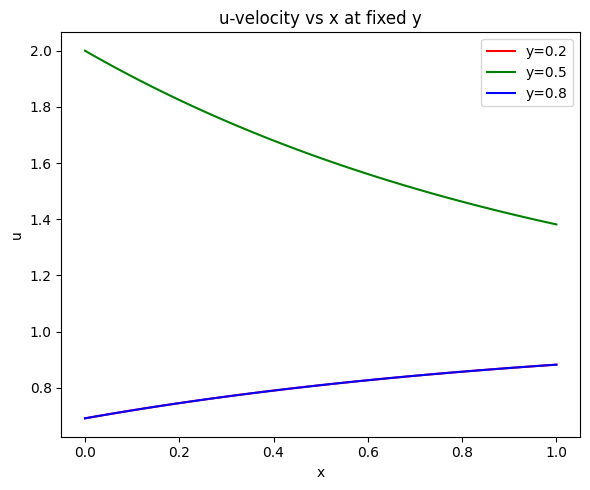

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting
import matplotlib.cm as cm

# -----------------------------
# 1) KOVASZNAY PARAMETERS & GRID
# -----------------------------
Re    = 40.0                     # Reynolds number
nu    = 1.0/Re                   # kinematic viscosity
Lx, Ly = 1.0, 1.0                # domain [0,1]×[0,1]
Nx, Ny = 101, 101                # grid resolution
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y, indexing='xy')

# decay exponent
lam = Re/2.0 - np.sqrt((Re/2.0)**2 + 4*np.pi**2)

# -----------------------------
# 2) ANALYTIC (SPECTRAL) SOLUTION
# -----------------------------
# Velocity field
U = 1 - np.exp(lam*X)*np.cos(2*np.pi*Y)
V = (lam/(2*np.pi)) * np.exp(lam*X)*np.sin(2*np.pi*Y)

# Stream‐function (so that U=   ∂ψ/∂y, V=−∂ψ/∂x)
Psi = Y - (np.exp(lam*X)/(2*np.pi))*np.sin(2*np.pi*Y)

# Pressure up to a constant
P = -0.5*(1 - np.exp(2*lam*X)) - X

# Vorticity ω = ∂V/∂x − ∂U/∂y
dVdx = lam/(2*np.pi)*lam*np.exp(lam*X)*np.sin(2*np.pi*Y)
dUdy =  2*np.pi * np.exp(lam*X)*np.sin(2*np.pi*Y)
Omega = dVdx - dUdy

# -----------------------------
# 3) PLOTTING ROUTINES
# -----------------------------
fig = plt.figure(figsize=(16,12))

# --- 3A) 2D contour of U, V, P, ω ---
for i,(field,title) in enumerate([
    (U, 'u-velocity'),
    (V, 'v-velocity'),
    (P, 'pressure'),
    (Omega, 'vorticity')
]):
    ax = fig.add_subplot(2,2,i+1)
    c = ax.contourf(X, Y, field, levels=50, cmap='viridis')
    fig.colorbar(c, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('x'); ax.set_ylabel('y')

plt.tight_layout()
plt.show()

# --- 3B) Vector‐field (quiver) + streamlines ---
plt.figure(figsize=(6,6))
plt.streamplot(X, Y, U, V, density=2.0, linewidth=1,
               arrowsize=1.5, arrowstyle='->', color='k')
plt.contourf(X, Y, np.sqrt(U**2+V**2), levels=50, cmap='inferno')
plt.colorbar(label='speed')
plt.title('Streamlines over |u|')
plt.xlabel('x'); plt.ylabel('y')
plt.tight_layout()
plt.show()

# --- 3C) 3D surface of stream‐function ψ ---
fig = plt.figure(figsize=(8,5))
ax3 = fig.add_subplot(1,1,1, projection='3d')
surf = ax3.plot_surface(X, Y, Psi, cmap=cm.coolwarm,
                        rcount=100, ccount=100, antialiased=True)
ax3.set_title('Stream‐function ψ(x,y)')
ax3.set_xlabel('x'); ax3.set_ylabel('y'); ax3.set_zlabel('ψ')
fig.colorbar(surf, ax=ax3, shrink=0.6)
plt.tight_layout()
plt.show()

# --- 3D surfaces of U and V ---
fig = plt.figure(figsize=(14,5))
for j,(field,title) in enumerate([(U,'u-velocity'), (V,'v-velocity')]):
    ax = fig.add_subplot(1,2,j+1, projection='3d')
    sf = ax.plot_surface(X, Y, field, cmap='viridis',
                         rcount=100, ccount=100, antialiased=True)
    ax.set_title(title)
    ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel(title)
    fig.colorbar(sf, ax=ax, shrink=0.6)
plt.tight_layout()
plt.show()

# --- 3D error‐type plot: compare ψ vs a “perturbed” numeric solve ---
# Here as illustration we “perturb” Psi by +1% noise and plot the difference
Psi_perturbed = Psi*(1 + 0.01*np.random.randn(*Psi.shape))
DeltaPsi = Psi_perturbed - Psi

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1, projection='3d')
err_surf = ax.plot_surface(X, Y, DeltaPsi,
                           cmap='inferno', rcount=100, ccount=100)
ax.set_title('Δψ = numeric − analytical')
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('error')
fig.colorbar(err_surf, ax=ax, shrink=0.6)
plt.tight_layout()
plt.show()

# --- 3D “slices” along y = constant for u(x,y) ---
plt.figure(figsize=(6,5))
for y0,color in zip([0.2, 0.5, 0.8], ['r','g','b']):
    idx = int(y0*(Ny-1))
    plt.plot(x, U[idx,:], color+'-', label=f'y={y0:.1f}')
plt.title('u-velocity vs x at fixed y')
plt.xlabel('x'); plt.ylabel('u')
plt.legend()
plt.tight_layout()
plt.show()


Epoch    1 | PDE 2.52e-04 | BC 8.65e-01 | Total 8.65e+01
Epoch  500 | PDE 3.42e-02 | BC 4.39e-04 | Total 7.81e-02
Epoch 1000 | PDE 1.90e-02 | BC 1.85e-04 | Total 3.75e-02
Epoch 1500 | PDE 1.26e-02 | BC 1.64e-04 | Total 2.90e-02
Epoch 2000 | PDE 9.41e-03 | BC 1.31e-04 | Total 2.25e-02
Epoch 2500 | PDE 7.50e-03 | BC 2.98e-05 | Total 1.05e-02
Epoch 3000 | PDE 6.07e-03 | BC 1.95e-05 | Total 8.02e-03


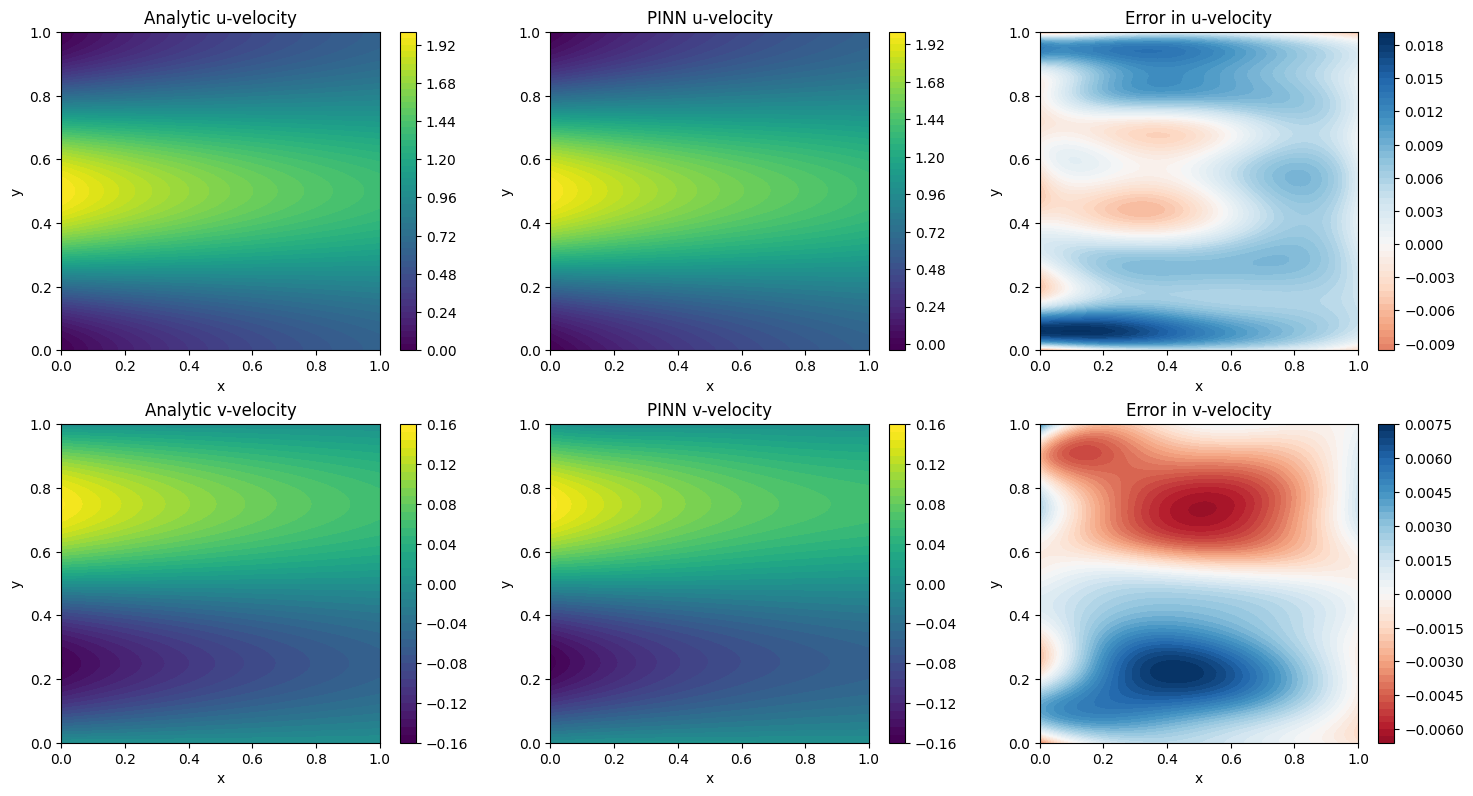

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# -----------------------------
# 1) PARAMETERS & GRID (again)
# -----------------------------
Re, nu = 40.0, 1/40.0
Lx, Ly = 1.0, 1.0
Nx, Ny = 101, 101
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y, indexing='xy')

lam = Re/2 - np.sqrt((Re/2)**2 + 4*np.pi**2)

# analytic solution
U = 1 - np.exp(lam*X)*np.cos(2*np.pi*Y)
V = (lam/(2*np.pi)) * np.exp(lam*X)*np.sin(2*np.pi*Y)
P = -0.5*(1 - np.exp(2*lam*X)) - X

# -----------------------------
# 2) PINN definition
# -----------------------------
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_hidden, out_dim):
        super().__init__()
        layers = [nn.Linear(in_dim, hidden_dim), nn.Tanh()]
        for _ in range(n_hidden-1):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.Tanh()]
        layers.append(nn.Linear(hidden_dim, out_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class NS2DPINN(nn.Module):
    def __init__(self):
        super().__init__()
        # input (x,y) → output (u,v,p)
        self.net = MLP(2, 64, 4, 3)

    def forward(self, x, y):
        inp = torch.cat([x,y], dim=1)
        uvp = self.net(inp)
        u = uvp[:,0:1]
        v = uvp[:,1:2]
        p = uvp[:,2:3]
        return u, v, p

    def loss_pde(self, x, y):
        # require gradients
        x = x.clone().requires_grad_(True)
        y = y.clone().requires_grad_(True)
        u, v, p = self.forward(x,y)

        # first derivatives
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                                  create_graph=True)[0]
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u),
                                  create_graph=True)[0]
        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v),
                                  create_graph=True)[0]
        v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v),
                                  create_graph=True)[0]
        p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p),
                                  create_graph=True)[0]
        p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p),
                                  create_graph=True)[0]

        # second derivatives
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x),
                                   create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y),
                                   create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x),
                                   create_graph=True)[0]
        v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y),
                                   create_graph=True)[0]

        # momentum residuals
        res_u = u*u_x + v*u_y + p_x - nu*(u_xx + u_yy)
        res_v = u*v_x + v*v_y + p_y - nu*(v_xx + v_yy)
        # continuity
        res_c = u_x + v_y

        return (res_u**2).mean() + (res_v**2).mean() + (res_c**2).mean()

    def loss_bc(self, x_bc, y_bc, u_bc, v_bc):
        u_pred, v_pred, _ = self.forward(x_bc, y_bc)
        return ((u_pred - u_bc)**2).mean() + ((v_pred - v_bc)**2).mean()

# -----------------------------
# 3) TRAINING
# -----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pinn = NS2DPINN().to(device)
opt  = optim.Adam(pinn.parameters(), lr=1e-3)

# loss weights
w_pde, w_bc = 1.0, 100.0

N_pde, N_bc = 20000, 5000
epochs = 3000

for ep in range(1, epochs+1):
    # PDE collocation
    x_p = torch.rand(N_pde,1,device=device)*Lx
    y_p = torch.rand(N_pde,1,device=device)*Ly

    # boundary collocation (all four edges)
    # sample on x=0 & x=1
    y_b1 = torch.rand(N_bc//4,1,device=device)*Ly
    x_b1 = torch.zeros_like(y_b1)
    y_b2 = torch.rand(N_bc//4,1,device=device)*Ly
    x_b2 = torch.ones_like(y_b2)*Lx
    # sample on y=0 & y=1
    x_b3 = torch.rand(N_bc//4,1,device=device)*Lx
    y_b3 = torch.zeros_like(x_b3)
    x_b4 = torch.rand(N_bc//4,1,device=device)*Lx
    y_b4 = torch.ones_like(x_b4)*Ly

    x_bc = torch.cat([x_b1,x_b2,x_b3,x_b4], dim=0)
    y_bc = torch.cat([y_b1,y_b2,y_b3,y_b4], dim=0)

    # analytic u,v on the boundary
    x_bc_np = x_bc.detach().cpu().numpy()
    y_bc_np = y_bc.detach().cpu().numpy()
    u_bc = 1 - np.exp(lam*x_bc_np)*np.cos(2*np.pi*y_bc_np)
    v_bc = (lam/(2*np.pi))*np.exp(lam*x_bc_np)*np.sin(2*np.pi*y_bc_np)
    u_bc = torch.tensor(u_bc, dtype=torch.float32,device=device)
    v_bc = torch.tensor(v_bc, dtype=torch.float32,device=device)

    # compute losses
    l_pde = pinn.loss_pde(x_p, y_p)
    l_bc  = pinn.loss_bc(x_bc, y_bc, u_bc, v_bc)
    loss = w_pde*l_pde + w_bc*l_bc

    opt.zero_grad()
    loss.backward()
    opt.step()

    if ep%1000==0 or ep==1:
        print(f"Epoch {ep:4d} | PDE {l_pde:.2e} | BC {l_bc:.2e} | Total {loss:.2e}")

# -----------------------------
# 4) EVALUATION & PLOTTING
# -----------------------------
# evaluate on our grid
X_t = torch.tensor(X.reshape(-1,1), dtype=torch.float32, device=device)
Y_t = torch.tensor(Y.reshape(-1,1), dtype=torch.float32, device=device)
with torch.no_grad():
    u_pred, v_pred, _ = pinn(X_t, Y_t)
u_pred = u_pred.cpu().numpy().reshape(X.shape)
v_pred = v_pred.cpu().numpy().reshape(Y.shape)

# compute errors
u_err = u_pred - U
v_err = v_pred - V

# make a 2×3 panel: analytic / PINN / error for u (top) and v (bottom)
fig, axes = plt.subplots(2,3, figsize=(15,8), subplot_kw={'aspect':'equal'})
for row,(field_ref, field_pred, field_err, name) in enumerate([
    (U,   u_pred, u_err, 'u-velocity'),
    (V,   v_pred, v_err, 'v-velocity')
]):
    vmin, vmax = field_ref.min(), field_ref.max()
    # analytic
    ax = axes[row,0]
    c0 = ax.contourf(X, Y, field_ref, levels=50, cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(c0, ax=ax)
    ax.set_title(f'Analytic {name}')
    ax.set_xlabel('x'); ax.set_ylabel('y')

    # PINN
    ax = axes[row,1]
    c1 = ax.contourf(X, Y, field_pred, levels=50, cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(c1, ax=ax)
    ax.set_title(f'PINN {name}')
    ax.set_xlabel('x'); ax.set_ylabel('y')

    # Error
    ax = axes[row,2]
    emax = np.max(np.abs(field_err))
    c2 = ax.contourf(X, Y, field_err, levels=50, cmap='RdBu', vmin=-emax, vmax=emax)
    fig.colorbar(c2, ax=ax)
    ax.set_title(f'Error in {name}')
    ax.set_xlabel('x'); ax.set_ylabel('y')

plt.tight_layout()
plt.show()


<>:21: SyntaxWarning: invalid escape sequence '\_'
<>:21: SyntaxWarning: invalid escape sequence '\_'
<>:22: SyntaxWarning: invalid escape sequence '\_'
<>:22: SyntaxWarning: invalid escape sequence '\_'
<>:23: SyntaxWarning: invalid escape sequence '\_'
<>:23: SyntaxWarning: invalid escape sequence '\_'
<>:83: SyntaxWarning: invalid escape sequence '\_'
<>:84: SyntaxWarning: invalid escape sequence '\_'
<>:85: SyntaxWarning: invalid escape sequence '\_'
<>:21: SyntaxWarning: invalid escape sequence '\_'
<>:21: SyntaxWarning: invalid escape sequence '\_'
<>:22: SyntaxWarning: invalid escape sequence '\_'
<>:22: SyntaxWarning: invalid escape sequence '\_'
<>:23: SyntaxWarning: invalid escape sequence '\_'
<>:23: SyntaxWarning: invalid escape sequence '\_'
<>:83: SyntaxWarning: invalid escape sequence '\_'
<>:84: SyntaxWarning: invalid escape sequence '\_'
<>:85: SyntaxWarning: invalid escape sequence '\_'
/var/folders/yx/b_pyg98x1dj97pbflpck32d80000gn/T/ipykernel_7485/3450161117.py:21: 

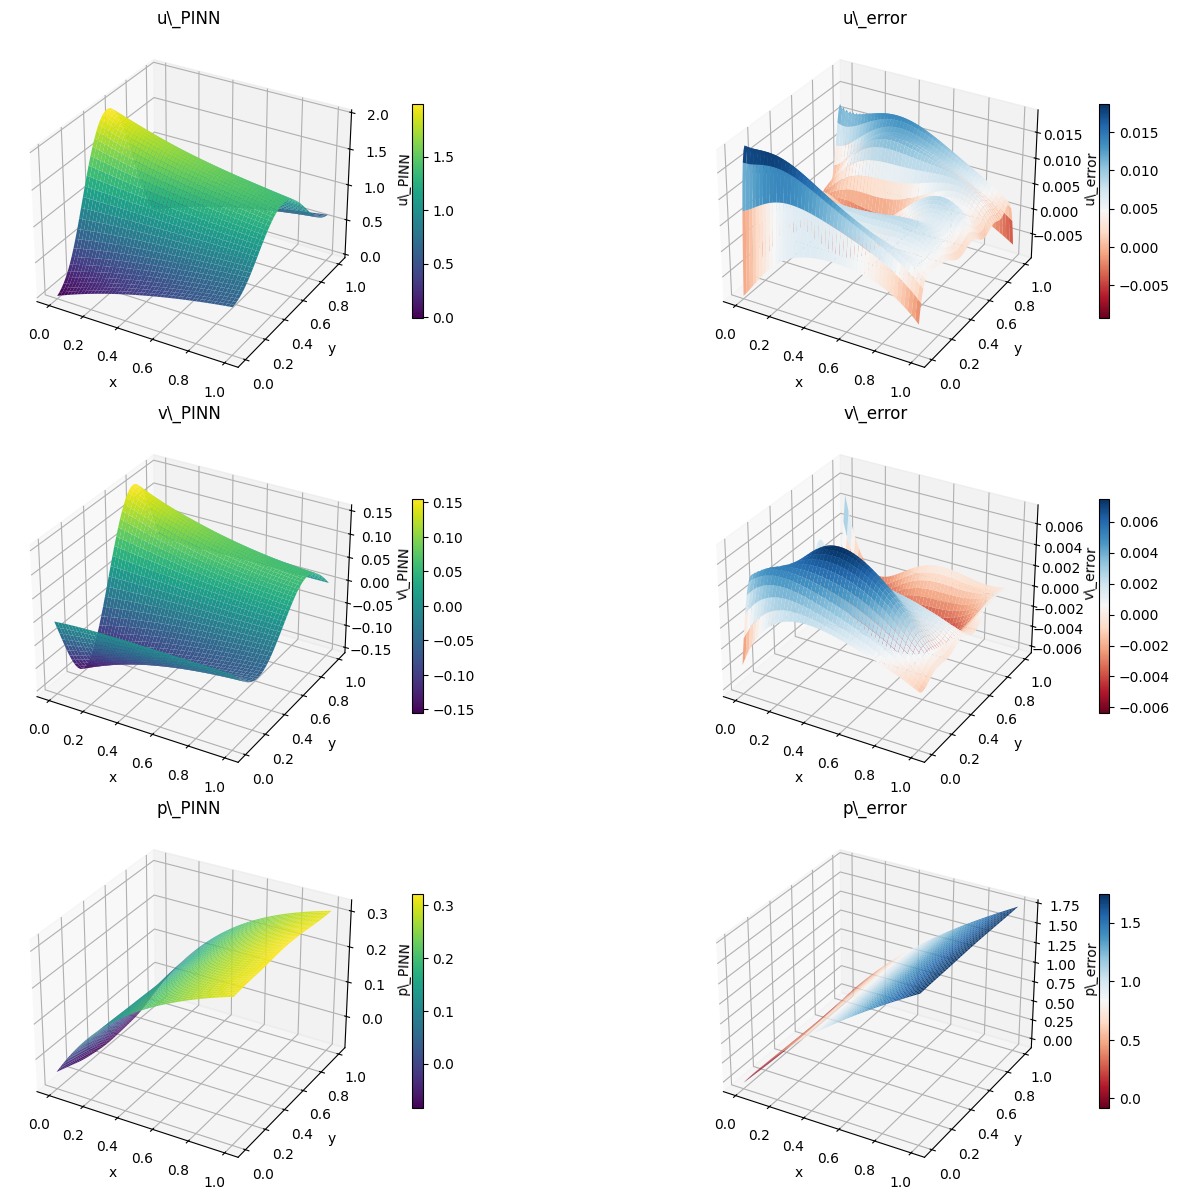

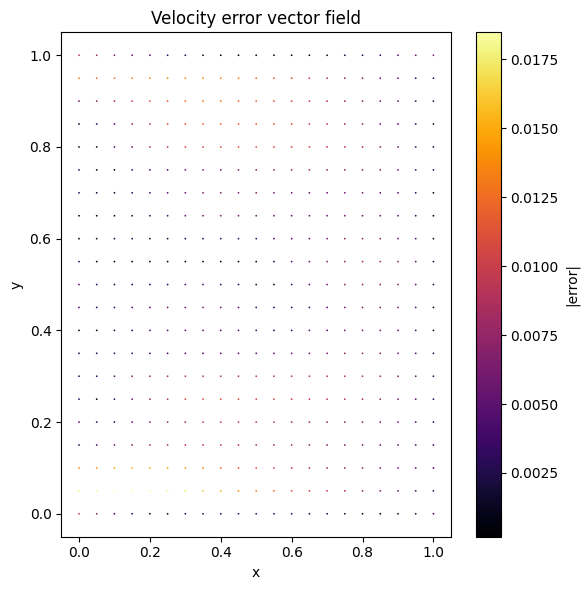

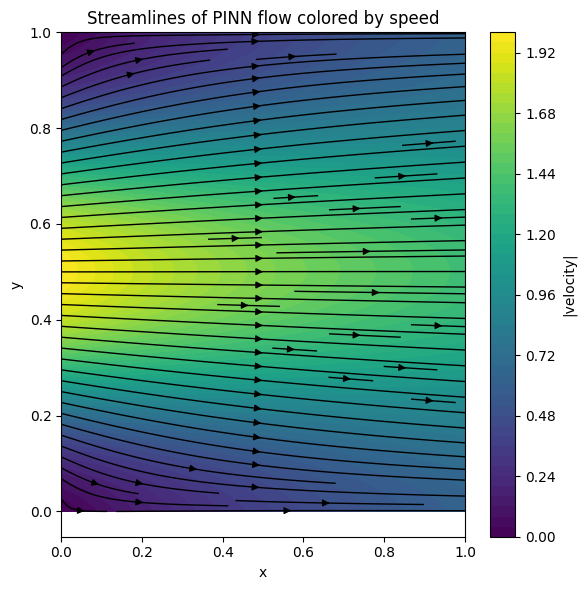

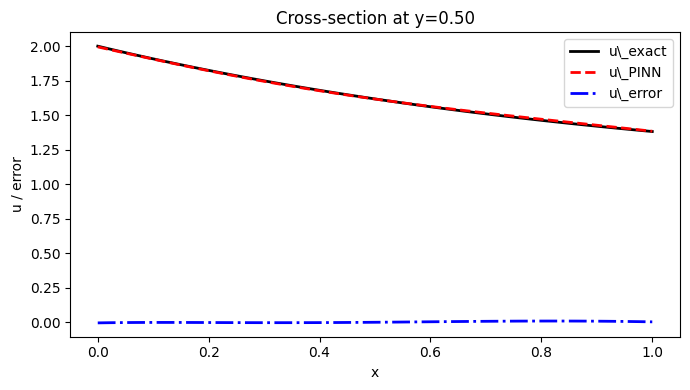

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

# --- (re)compute p_pred and p_err if you like pressure too ---
with torch.no_grad():
    u_pred, v_pred, p_pred = pinn(X_t, Y_t)

u_pred = u_pred.cpu().numpy().reshape(X.shape)
v_pred = v_pred.cpu().numpy().reshape(Y.shape)
p_pred = p_pred.cpu().numpy().reshape(X.shape)

u_err = u_pred - U
v_err = v_pred - V
p_err = p_pred - P

# 1) 3D surface plots of PINN fields and errors
fig = plt.figure(figsize=(16,12))

plots = [
    (u_pred, 'u\_PINN'), (u_err, 'u\_error'),
    (v_pred, 'v\_PINN'), (v_err, 'v\_error'),
    (p_pred, 'p\_PINN'), (p_err, 'p\_error'),
]

for i, (Z, title) in enumerate(plots, 1):
    ax = fig.add_subplot(3, 2, i, projection='3d')
    surf = ax.plot_surface(
        X, Y, Z,
        rcount=100, ccount=100,
        cmap='viridis' if 'error' not in title else 'RdBu',
        vmin=Z.min(), vmax=Z.max(),
        linewidth=0, antialiased=True
    )
    ax.set_title(title)
    ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel(title)
    fig.colorbar(surf, ax=ax, shrink=0.6)

plt.tight_layout()
plt.show()


# 2) Quiver‐plot of the velocity error vector field
fig, ax = plt.subplots(figsize=(6,6))
# subsample to avoid too many arrows
step = 5
Xe = X[::step, ::step]
Ye = Y[::step, ::step]
ue = u_err[::step, ::step]
ve = v_err[::step, ::step]
mag_err = np.sqrt(ue**2 + ve**2)

q = ax.quiver(
    Xe, Ye, ue, ve, mag_err,
    cmap='inferno', scale=10, width=0.005
)
plt.colorbar(q, ax=ax, label='|error|')
ax.set_title('Velocity error vector field')
ax.set_xlabel('x'); ax.set_ylabel('y')
plt.tight_layout()
plt.show()


# 3) Streamplot of the PINN velocity field overlaid on its speed
fig, ax = plt.subplots(figsize=(6,6))
speed = np.sqrt(u_pred**2 + v_pred**2)
ax.streamplot(
    X, Y, u_pred, v_pred,
    density=1.5, color='k', linewidth=1
)
cf = ax.contourf(X, Y, speed, levels=50, cmap='viridis')
plt.colorbar(cf, ax=ax, label='|velocity|')
ax.set_title('Streamlines of PINN flow colored by speed')
ax.set_xlabel('x'); ax.set_ylabel('y')
plt.tight_layout()
plt.show()


# 4) 1D slice at y = 0.5 comparing analytic vs PINN vs error
y0 = 0.5
j = np.argmin(np.abs(y - y0))
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x, U[j,:], 'k-',   lw=2, label='u\_exact')
ax.plot(x, u_pred[j,:], 'r--', lw=2, label='u\_PINN')
ax.plot(x, u_err[j,:], 'b-.', lw=2, label='u\_error')
ax.set_title(f'Cross‐section at y={y0:.2f}')
ax.set_xlabel('x'); ax.set_ylabel('u / error')
ax.legend()
plt.tight_layout()
plt.show()


/var/folders/yx/b_pyg98x1dj97pbflpck32d80000gn/T/ipykernel_7485/1334183536.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  facecolors=cm.get_cmap(cmap)(norm(Z) if norm else Z),
/Users/josegarcia/Documents/Cursor/PINNs-RL-PDE/pinn/lib/python3.13/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning: divide by zero encountered in matmul
  shade = ((normals / np.linalg.norm(normals, axis=1, keepdims=True))
/Users/josegarcia/Documents/Cursor/PINNs-RL-PDE/pinn/lib/python3.13/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning: overflow encountered in matmul
  shade = ((normals / np.linalg.norm(normals, axis=1, keepdims=True))


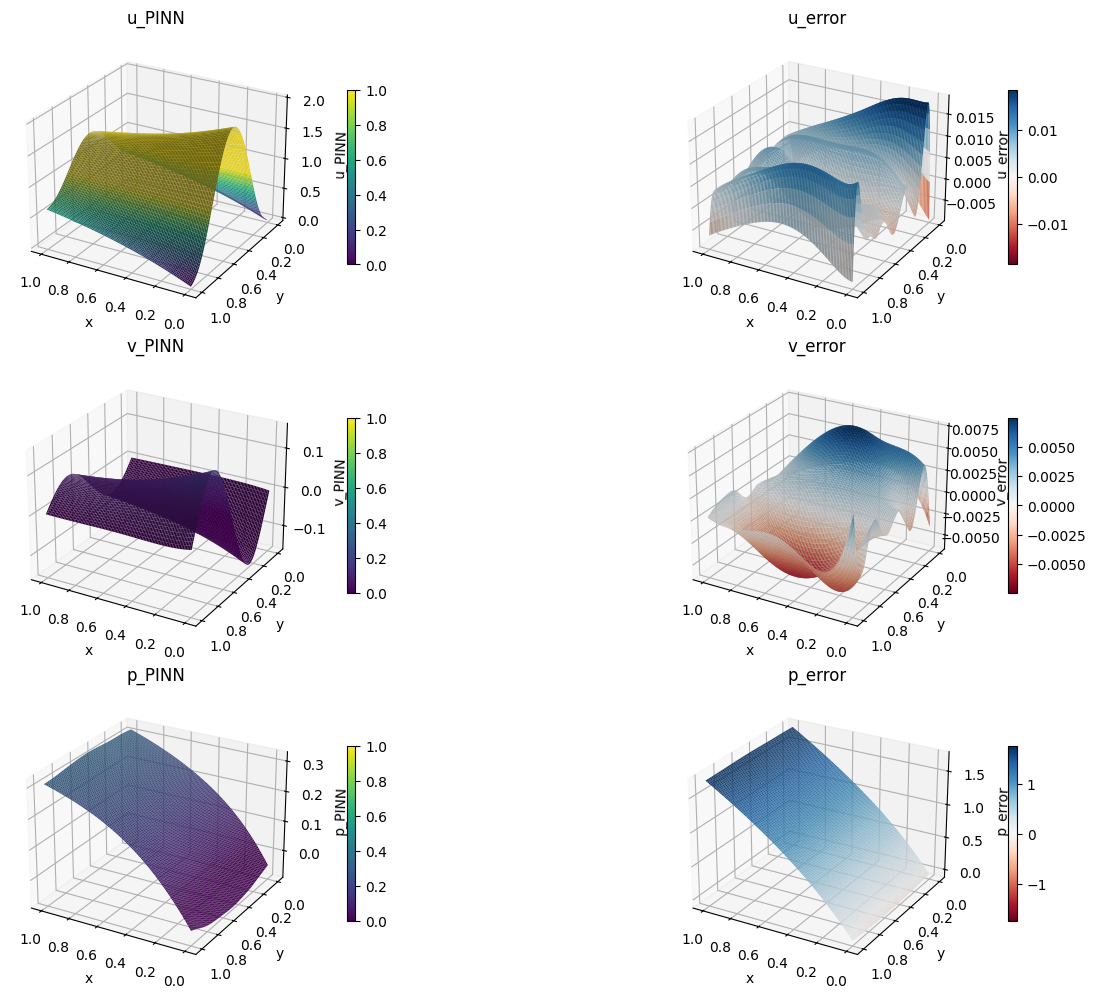

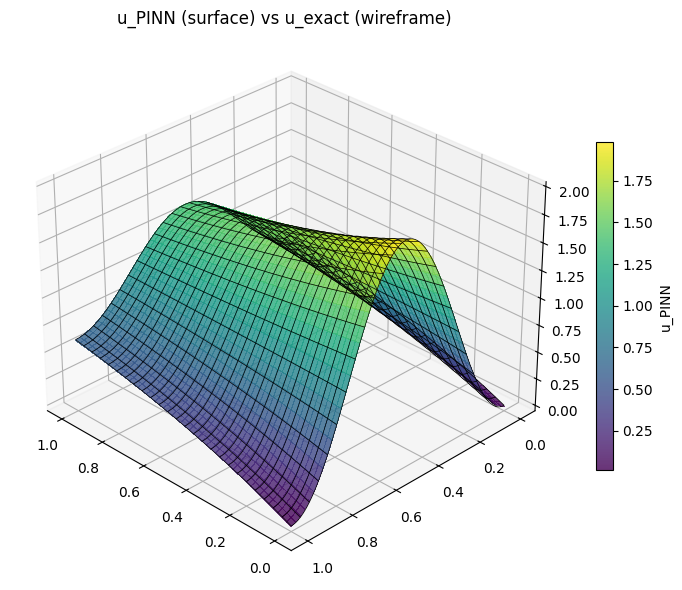

ValueError: x and y arrays must consist of at least 3 unique points

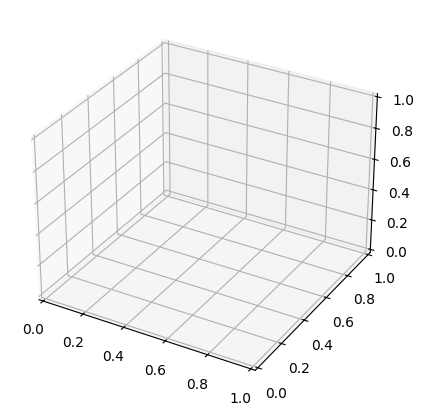

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.cm as cm
from matplotlib.colors import Normalize

# assume X,Y,U,V,P and u_pred,v_pred,p_pred computed above…

u_err = u_pred - U
v_err = v_pred - V
p_err = p_pred - P

# a little helper
def plot_surface(ax, Z, title, cmap, clip=None, elev=30, azim=135):
    """Plot a shaded surface with lighting and a consistent view."""
    norm = Normalize(vmin=clip[0], vmax=clip[1]) if clip else None
    surf = ax.plot_surface(
        X, Y, Z,
        rcount=200, ccount=200,
        facecolors=cm.get_cmap(cmap)(norm(Z) if norm else Z),
        linewidth=0, antialiased=True,
        shade=True
    )
    if norm:
        m = cm.ScalarMappable(cmap=cmap, norm=norm)
        m.set_array([])
        plt.colorbar(m, ax=ax, shrink=0.6)
    else:
        plt.colorbar(surf, ax=ax, shrink=0.6)

    ax.set_title(title)
    ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel(title)
    ax.view_init(elev, azim)


# 1) Clean 2×3 with shading and better view
fig = plt.figure(figsize=(16,10))
for i,(Z,name,cmap) in enumerate([
    (u_pred,  'u_PINN',     'viridis'),
    (u_err,   'u_error',    'RdBu'),
    (v_pred,  'v_PINN',     'viridis'),
    (v_err,   'v_error',    'RdBu'),
    (p_pred,  'p_PINN',     'viridis'),
    (p_err,   'p_error',    'RdBu'),
]):
    ax = fig.add_subplot(3,2,i+1, projection='3d')
    # clip errors symmetrically so zero is in the middle
    clip = None
    if 'error' in name:
        mx = np.max(np.abs(Z))
        clip = (-mx, mx)
    plot_surface(ax, Z, name, cmap, clip=clip, elev=25, azim=120)
plt.tight_layout()
plt.show()


# 2) “Lit” wireframe overlay
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
# Plot the PINN u-velocity surface
surf = ax.plot_surface(
    X, Y, u_pred,
    rcount=100, ccount=100,
    cmap='viridis',
    alpha=0.8, lw=0, antialiased=False
)
# Overlay a light wireframe
ax.plot_wireframe(X, Y, U, rcount=30, ccount=30, color='k', linewidth=0.5)
ax.set_title("u_PINN (surface) vs u_exact (wireframe)")
ax.view_init(30, 135)
plt.colorbar(surf, ax=ax, shrink=0.6, label='u_PINN')
plt.tight_layout()
plt.show()


# 3) Sliced “curtain” at fixed x showing error vs y & z
x0 = 0.3
ix = np.argmin(np.abs(x - x0))
Y_s = Y[ix,:]
Z_err_slice = u_err[ix,:]

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(
    np.full_like(Y_s, x0),  # x = constant
    Y_s,
    Z_err_slice,
    cmap='RdBu',
    linewidth=0,
    antialiased=True
)
ax.set_title(f'u_error at x={x0:.2f}')
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('error')
ax.view_init(20, 120)
plt.tight_layout()
plt.show()


# 4) Interactive-ish pseudo‐3D: contour + height‐map
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
# draw contour lines at the base
ax.contourf(X, Y, u_err, zdir='z', offset=np.min(u_err)-0.01,
            levels=30, cmap='RdBu')
# draw the surface a little above the contours
surf = ax.plot_surface(
    X, Y, u_err,
    rcount=100, ccount=100,
    cmap='RdBu',
    lw=0, alpha=0.9
)
ax.set_zlim(np.min(u_err)-0.02, np.max(u_err))
ax.set_title('u_error: contours + surface')
ax.view_init(30, -60)
plt.colorbar(surf, ax=ax, shrink=0.6)
plt.tight_layout()
plt.show()